In [ ]:
# Bonus
# Implementing ResNet-34
import os
import scipy.io as sio
import torch
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Loading labels using file proived on website
labels = sio.loadmat('imagelabels.mat')['labels'][0]
all_image_ids = [f'image_{i+1:05d}.jpg' for i in range(len(labels))]
all_labels = [labels[i] - 1 for i in range(len(labels))]

# Splitting into training, validation, and test sets (80-10-10)
train_id, temp_id, train_labels, temp_labels = train_test_split(
    all_image_ids, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)
val_ids, test_ids, val_labels, test_labels = train_test_split(
    temp_id, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

# Defining custom Dataset class
class FlowerDataset(Dataset):
    def __init__(self, image_ids, labels, img_dir, transform=None):
        self.image_ids = image_ids
        self.labels = labels
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.image_ids[idx])
        image = Image.open(img_name).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Paths to my drive folder
img_dir = '/content/drive/MyDrive/jpg'

# Creating datasets using dataset class defined above
train_dataset = FlowerDataset(train_id, train_labels, img_dir, transform=transform)
val_dataset = FlowerDataset(val_ids, val_labels, img_dir, transform=transform)
test_dataset = FlowerDataset(test_ids, test_labels, img_dir, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# `train_loader`, `val_loader`, and `test_loader` are ready for training, validation, and testing


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau


# data augmentation for training
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# Defining ResNet-34 architecture
class SimpleBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(SimpleBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=102):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(512 * block.expansion, num_classes)
        )

    def _make_layer(self, block, planes, num_blocks, stride):
        layers = [block(self.in_planes, planes, stride)]
        self.in_planes = planes * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = nn.ReLU()(self.bn1(self.conv1(x)))
        x = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Instantiating the model, optimizer and scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet(SimpleBlock, [3, 4, 6, 3]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)


In [ ]:
# Traininging function with accuracy and loss tracking
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=30):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # Training Phase
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (preds == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation Phase
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (preds == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        # Scheduler step
        scheduler.step(avg_val_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
              f"Train Acc: {train_accuracy * 100:.2f}%, Val Acc: {val_accuracy * 100:.2f}%, "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

# training
train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(
    model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=30
)

Epoch [1/30], Train Loss: 4.2524, Val Loss: 3.6510, Train Acc: 6.46%, Val Acc: 10.13%, LR: 0.001000


Epoch [2/30], Train Loss: 3.6453, Val Loss: 3.3695, Train Acc: 11.20%, Val Acc: 14.41%, LR: 0.001000


Epoch [3/30], Train Loss: 3.3869, Val Loss: 3.2767, Train Acc: 14.41%, Val Acc: 15.75%, LR: 0.001000


Epoch [4/30], Train Loss: 3.1928, Val Loss: 3.1472, Train Acc: 17.55%, Val Acc: 22.34%, LR: 0.001000


Epoch [5/30], Train Loss: 2.9984, Val Loss: 2.8333, Train Acc: 22.07%, Val Acc: 25.64%, LR: 0.001000


Epoch [6/30], Train Loss: 2.7824, Val Loss: 2.4565, Train Acc: 26.10%, Val Acc: 33.21%, LR: 0.001000


Epoch [7/30], Train Loss: 2.5984, Val Loss: 2.5131, Train Acc: 30.30%, Val Acc: 35.78%, LR: 0.001000


Epoch [8/30], Train Loss: 2.3910, Val Loss: 2.1708, Train Acc: 34.73%, Val Acc: 41.03%, LR: 0.001000


Epoch [9/30], Train Loss: 2.2141, Val Loss: 1.9043, Train Acc: 39.18%, Val Acc: 48.47%, LR: 0.001000


Epoch [10/30], Train Loss: 2.0522, Val Loss: 1.8800, Train Acc: 42.63%, Val Acc: 48.47%, LR: 0.001000


Epoch [11/30], Train Loss: 1.9133, Val Loss: 1.6981, Train Acc: 46.37%, Val Acc: 53.97%, LR: 0.001000


Epoch [12/30], Train Loss: 1.7922, Val Loss: 1.7913, Train Acc: 49.96%, Val Acc: 50.43%, LR: 0.001000


Epoch [13/30], Train Loss: 1.6551, Val Loss: 1.7576, Train Acc: 53.06%, Val Acc: 52.75%, LR: 0.001000


Epoch [14/30], Train Loss: 1.5420, Val Loss: 1.6231, Train Acc: 56.19%, Val Acc: 57.14%, LR: 0.001000


Epoch [15/30], Train Loss: 1.3983, Val Loss: 1.5030, Train Acc: 59.33%, Val Acc: 59.95%, LR: 0.001000


Epoch [16/30], Train Loss: 1.2809, Val Loss: 1.4760, Train Acc: 62.71%, Val Acc: 59.46%, LR: 0.001000


Epoch [17/30], Train Loss: 1.1429, Val Loss: 1.4153, Train Acc: 66.07%, Val Acc: 61.78%, LR: 0.001000


Epoch [18/30], Train Loss: 1.0477, Val Loss: 1.3949, Train Acc: 68.81%, Val Acc: 62.03%, LR: 0.001000


Epoch [19/30], Train Loss: 0.9162, Val Loss: 1.3398, Train Acc: 72.55%, Val Acc: 62.64%, LR: 0.001000


Epoch [20/30], Train Loss: 0.8105, Val Loss: 1.3511, Train Acc: 75.61%, Val Acc: 65.20%, LR: 0.001000


Epoch [21/30], Train Loss: 0.7074, Val Loss: 1.3601, Train Acc: 78.84%, Val Acc: 65.93%, LR: 0.001000


Epoch [22/30], Train Loss: 0.6181, Val Loss: 1.4225, Train Acc: 80.81%, Val Acc: 63.98%, LR: 0.001000


Epoch [23/30], Train Loss: 0.4791, Val Loss: 1.4332, Train Acc: 85.21%, Val Acc: 65.32%, LR: 0.001000


Epoch [24/30], Train Loss: 0.4338, Val Loss: 1.3874, Train Acc: 86.17%, Val Acc: 66.91%, LR: 0.001000


Epoch [25/30], Train Loss: 0.3858, Val Loss: 1.5331, Train Acc: 88.11%, Val Acc: 65.08%, LR: 0.000500


Epoch [26/30], Train Loss: 0.1878, Val Loss: 1.2034, Train Acc: 94.38%, Val Acc: 71.79%, LR: 0.000500


Epoch [27/30], Train Loss: 0.1011, Val Loss: 1.2615, Train Acc: 97.50%, Val Acc: 72.04%, LR: 0.000500


Epoch [28/30], Train Loss: 0.0833, Val Loss: 1.1913, Train Acc: 98.09%, Val Acc: 72.16%, LR: 0.000500


Epoch [29/30], Train Loss: 0.0817, Val Loss: 1.2188, Train Acc: 98.02%, Val Acc: 73.26%, LR: 0.000500


Epoch [30/30], Train Loss: 0.0637, Val Loss: 1.2793, Train Acc: 98.40%, Val Acc: 73.26%, LR: 0.000500


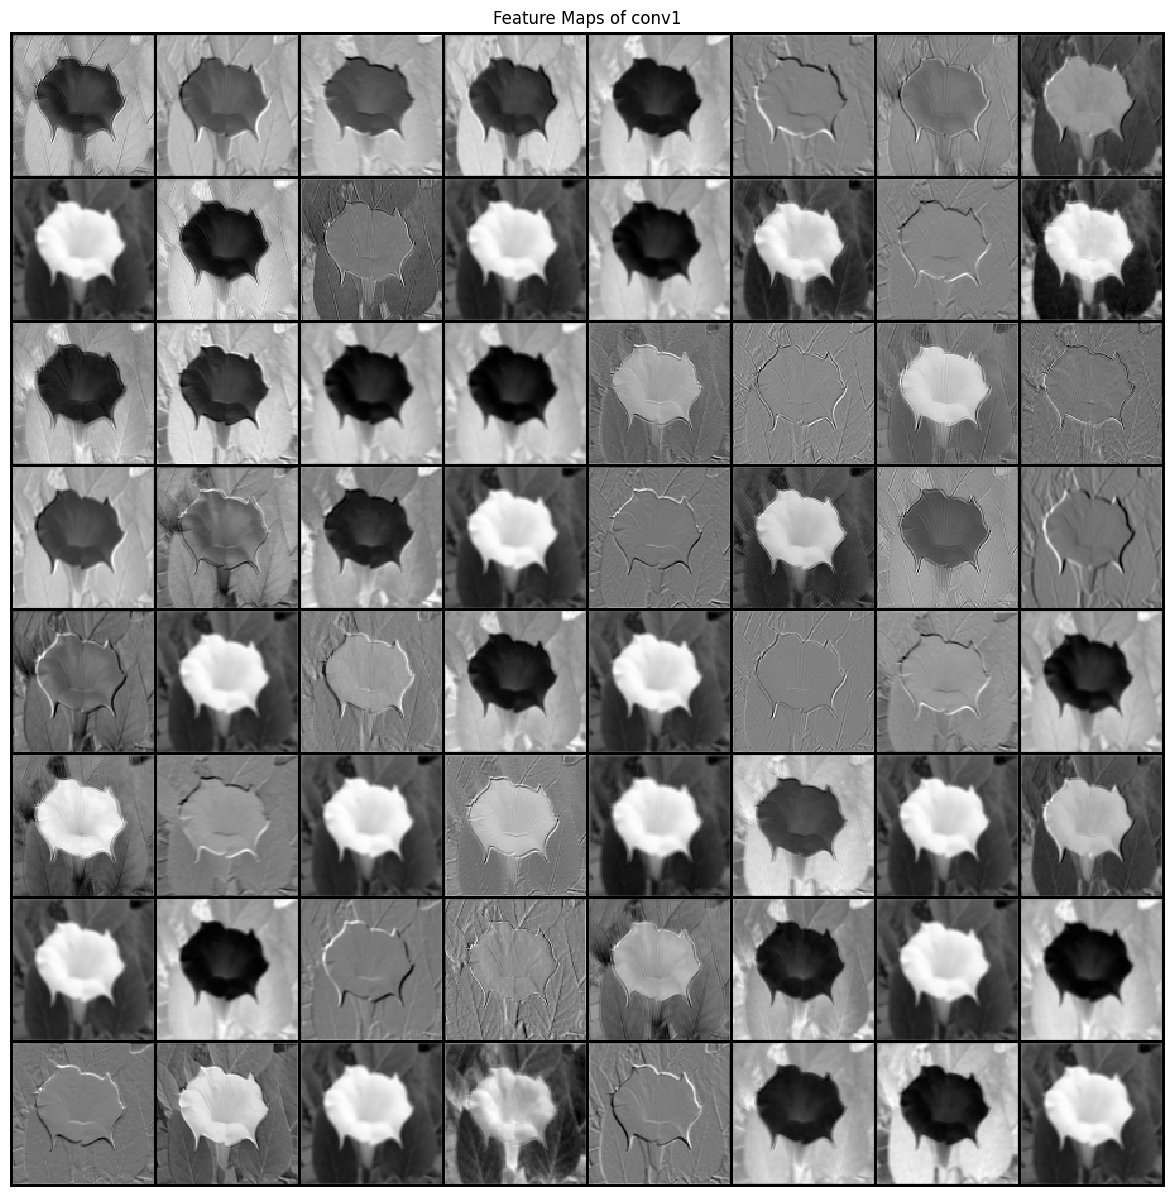

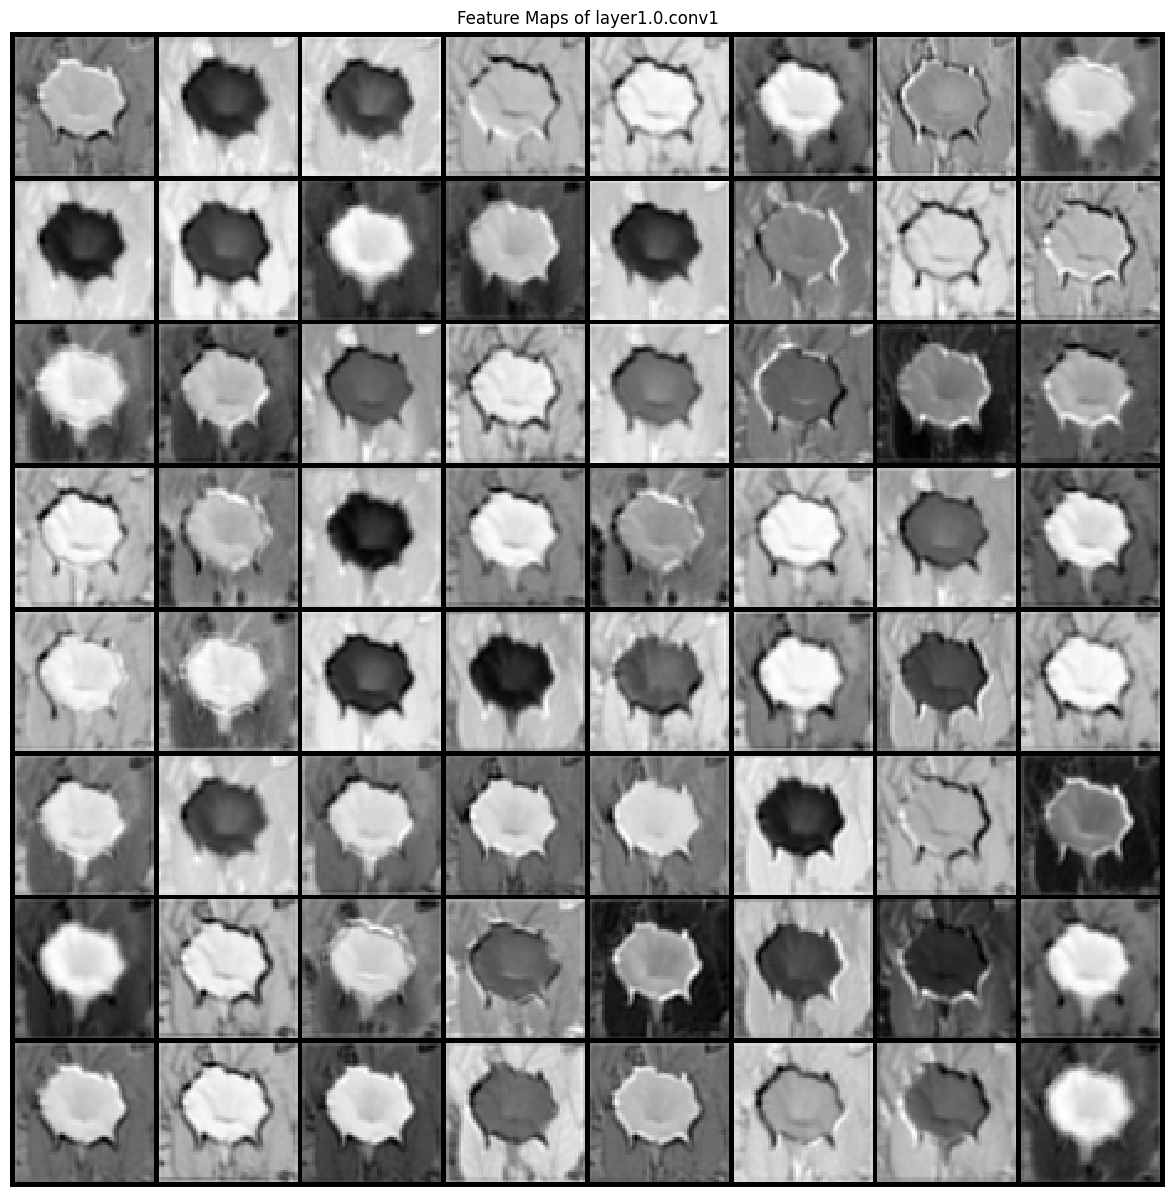

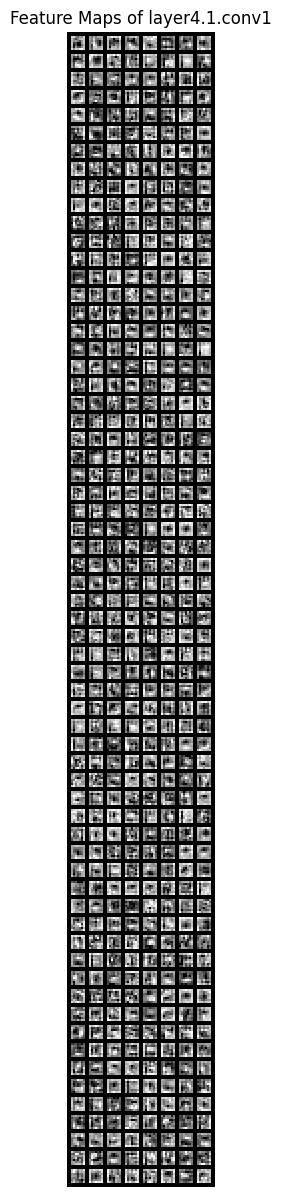

In [ ]:
# Model’s Interpretability

import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# 1. Function to visualize feature maps
def visualize_feature_maps(feature_maps, title):
    num_feature_maps = feature_maps.size(1)
    grid = make_grid(feature_maps[0].unsqueeze(1), nrow=8, normalize=True, scale_each=True)  # Only display the first image in the batch
    plt.figure(figsize=(15, 15))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), interpolation='nearest')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Hook function
feature_maps = {}
def hook_fn(module, input, output, layer_name):
    feature_maps[layer_name] = output

# Registering hooks on specific layers for early, middle, and late feature maps
layer_names = ['conv1', 'layer1.0.conv1', 'layer4.1.conv1']
hooks = []
for name in layer_names:
    layer = dict([*model.named_modules()])[name]
    hooks.append(layer.register_forward_hook(lambda m, i, o, name=name: hook_fn(m, i, o, name)))

# Running a forward pass to capture feature maps
sample_image, _ = next(iter(val_loader))  
sample_image = sample_image[:1].to(device) # using one image
model.eval()
with torch.no_grad():
    _ = model(sample_image)

# Visualizing the feature maps for layers
for layer_name in layer_names:
    visualize_feature_maps(feature_maps[layer_name].cpu(), title=f"Feature Maps of {layer_name}")

# Removing hooks after capturing
for hook in hooks:
    hook.remove()


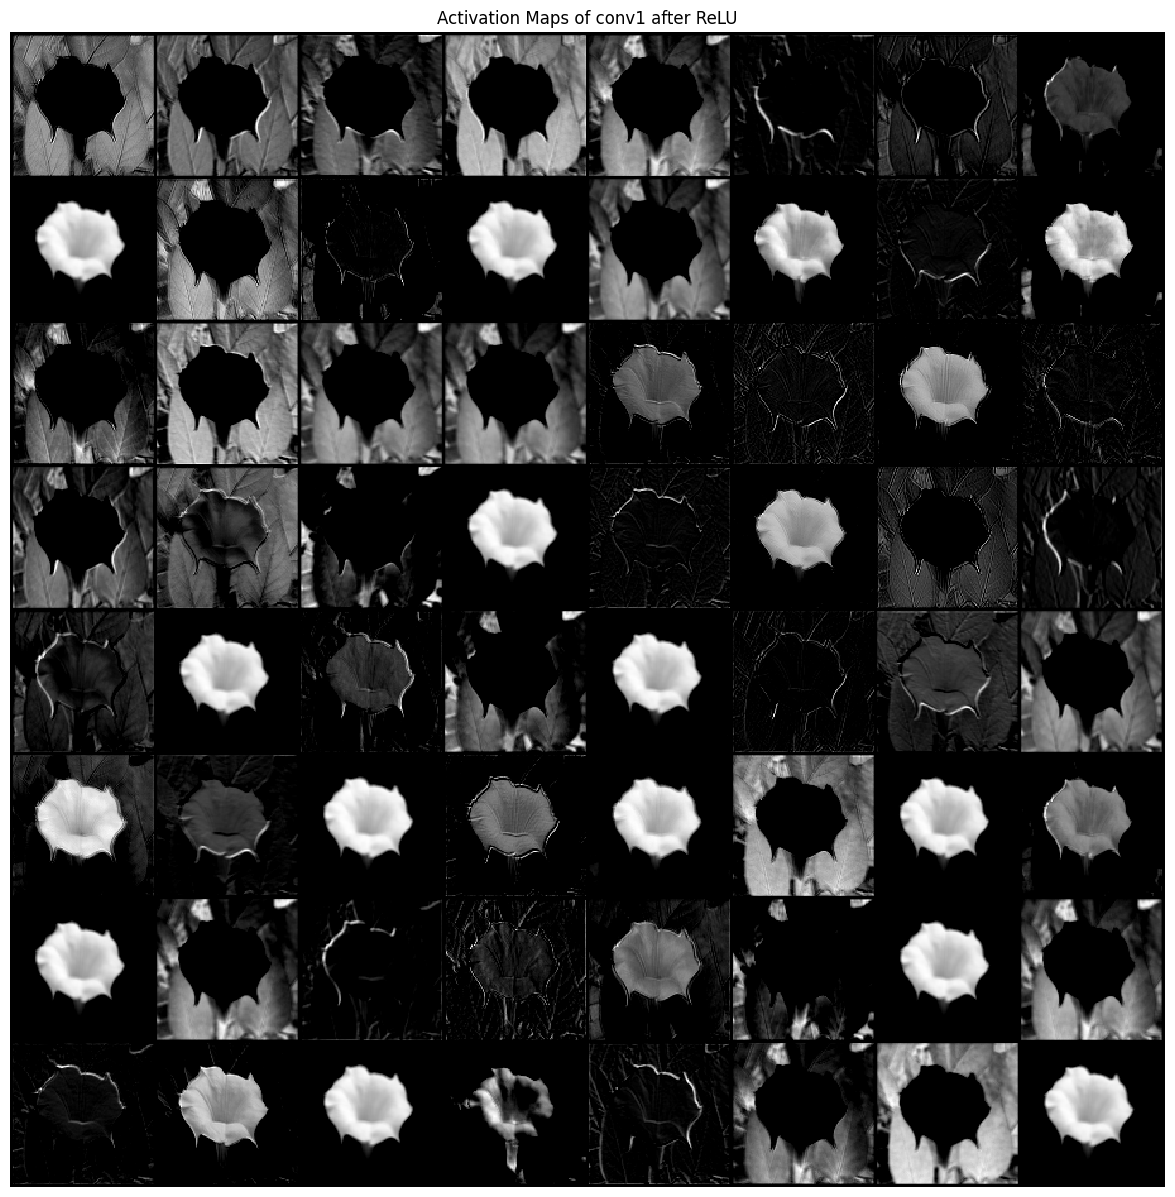

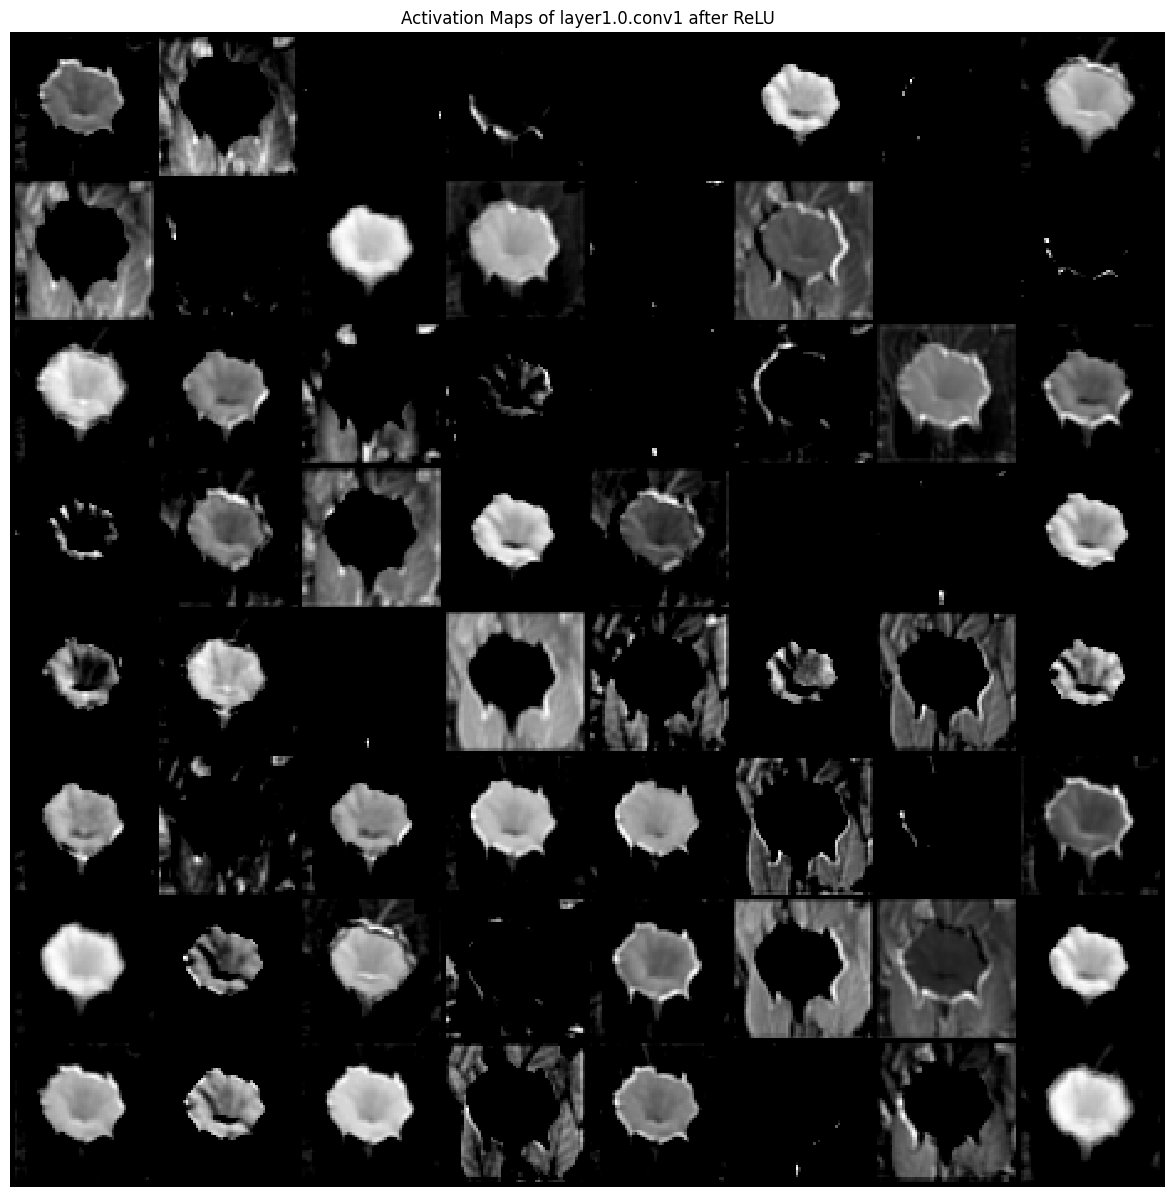

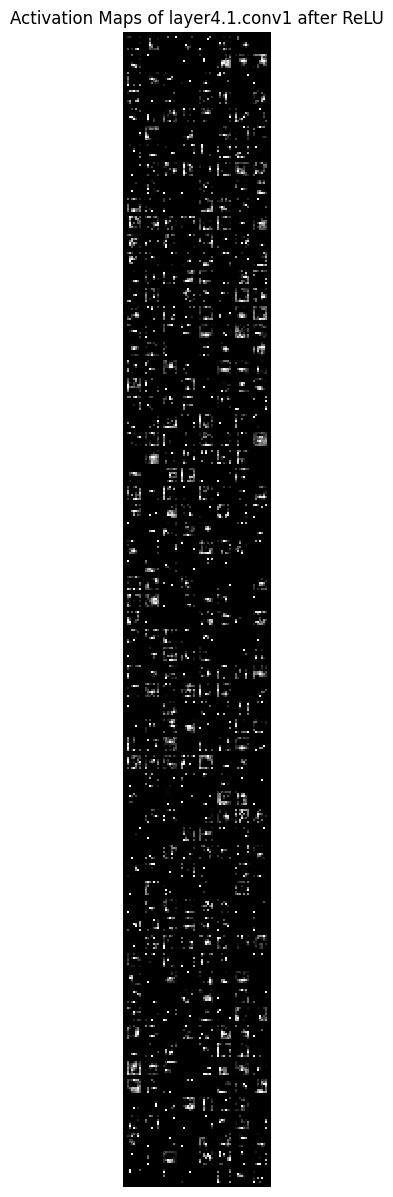

In [ ]:
import torch.nn.functional as F

# 2. Function to capture activation maps
activation_maps = {}
def activation_hook(module, input, output, layer_name):
    activation_maps[layer_name] = F.relu(output)  # Applying ReLU to the output

#  hooks for activation maps
activation_layer_names = ['conv1', 'layer1.0.conv1', 'layer4.1.conv1']
activation_hooks = []
for name in activation_layer_names:
    layer = dict([*model.named_modules()])[name]
    activation_hooks.append(layer.register_forward_hook(lambda m, i, o, name=name: activation_hook(m, i, o, name)))

# Forward pass to capture activation maps
model.eval()
with torch.no_grad():
    _ = model(sample_image)

# Visualizing activation maps
for layer_name in activation_layer_names:
    visualize_feature_maps(activation_maps[layer_name].cpu(), title=f"Activation Maps of {layer_name} after ReLU")

# Removing activation hooks
for hook in activation_hooks:
    hook.remove()


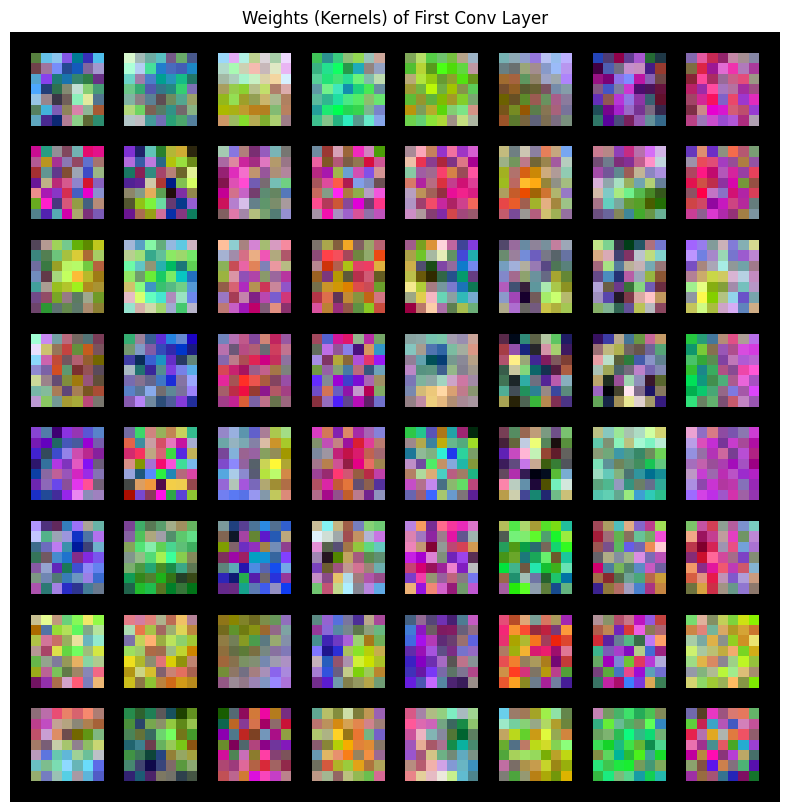

In [ ]:
#3. Function to visualize weights
def visualize_weights(weights, title):
    grid = make_grid(weights, nrow=8, normalize=True, scale_each=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), interpolation='nearest')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Visualizing weights (1st convolutional layer)
weights = model.conv1.weight.data.clone().cpu()
visualize_weights(weights, title="Weights (Kernels) of First Conv Layer")


# Types of Features Learned by ResNet-34

Deep network like ResNet-34 learns different types of features using different layers. Here's what I observed in the feature maps and the types of patterns captured by different layers:

## Early Layers (First Convolutional Layer)

- **What it Learns**: The network leans up on basic features like edges, lines and simple textures. 

- **Meaning**: These early filters act almost like edge detectors which help the network understand basic shapes and boundaries within the image.

- **Importance**: These fundamental features allows the model to start differentiating between different parts of an image which build the base for more detailed learning in later layers.

## Middle Layers

- **What it Learns**: As we move to the middle layers (like `layer1.0.conv1`), the network starts capturing more complex features like textures and corners.
- **Meaning**: These features might represent complext pattern like petal patterns, leaf textures that make each flower unique.
- **Importance**: This helps network gets a broader and deeper understanding of the image.

## Deeper Layers

- **What it Learns**: Deeper layers (like `layer4.1.conv1`) have abstract features that are unique to each category and hence learing these feautres helps the model distinguish one flower type from another.
- **Meaning**: For flower dataset the deeper layer features might be petal arrangement and differnt colors.
- **Importance**: When the network leans these unique and complex patterns it can classify flowers into differnt category more confidently by increasing the prediciton accuracy.


# References

### PyTorch
- [PyTorch Documentation](https://pytorch.org/docs/stable/index.html)
- [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)
- [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)
- [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) 
- [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- [nn.BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)
- [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
- [torch.optim](https://pytorch.org/docs/stable/optim.html)
- [ReduceLROnPlateau](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau)

### ResNet Architecture
- [ResNet Paper (arXiv)](https://arxiv.org/abs/1512.03385)
- [torchvision.models.resnet](https://pytorch.org/vision/stable/models.html#id2)


### Matplotlib
- [Matplotlib Documentation](https://matplotlib.org/stable/index.html)
- [torchvision.utils.make_grid](https://pytorch.org/vision/stable/utils.html#torchvision.utils.make_grid)

### Feature Maps and Hooks
- [Registering Hooks in PyTorch](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) 

### Dataset Splitting and Loading
- [scipy.io](https://docs.scipy.org/doc/scipy/tutorial/io.html) 
